In [8]:
import os
from math import sqrt
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

In [ ]:
class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(64, 64, 3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.conv(x))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input  = nn.Conv2d(1, 64, 3, padding=1, bias=False)
        self.residual_layer = nn.Sequential(*[Conv_ReLU_Block() for _ in range(18)])
        self.output = nn.Conv2d(64, 1, 3, padding=1, bias=False)
        self.relu   = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        return out + residual
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state   = torch.load("model_weights_vdsr_finetuned.pth", map_location=device, weights_only=False)
model  = Net().to(device)
model.load_state_dict(state, strict=True) 
model.eval()
print("VDSR weights loaded and model ready.")

lr_zip_path = 'merged_images'
hr_zip_path = 'image_hd'     


class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None, num_samples=None, upscale_factor=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted([f for f in os.listdir(lr_dir) if os.path.isfile(os.path.join(lr_dir, f))])
        self.hr_images = sorted([f for f in os.listdir(hr_dir) if os.path.isfile(os.path.join(hr_dir, f))])
        self.transform = transform
        self.num_samples = num_samples if num_samples is not None else len(self.lr_images)
        self.lr_images = self.lr_images[:self.num_samples]
        self.hr_images = self.hr_images[:self.num_samples]
        self.upscale_factor = upscale_factor

        if sorted(self.lr_images) != sorted(self.hr_images):
            raise ValueError("LR and HR image names do not match!")

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_image = Image.open(lr_path).convert("L")
        hr_image = Image.open(hr_path).convert("L")
        if self.upscale_factor is not None:
            lr_image = lr_image.resize((hr_image.width, hr_image.height), Image.BILINEAR)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

transform = ToTensor()
upscale_factor = 512 // 224 


num_training_samples = 500
train_dataset = SRDataset(lr_zip_path, hr_zip_path, transform=transform, num_samples=num_training_samples,upscale_factor=upscale_factor,)
train_dataloader = DataLoader(
     train_dataset,
     batch_size=2,    
     shuffle=True,
     num_workers=0  
 )

print(f"Training dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_dataloader)}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

num_epochs = 5 
print("Starting training...")

for epoch in range(num_epochs):
    epoch_loss = 0
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch_idx, (lr_images, hr_images) in pbar:
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)
            optimizer.zero_grad()
            outputs = model(lr_images)
            loss = criterion(outputs, hr_images)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")


final_weights_path = 'model_weights_vdsr_finetuned.pth'
torch.save(model.state_dict(), final_weights_path)
print(f"Fine-tuned model weights saved to: {final_weights_path}")


✅ VDSR weights loaded and model ready.
Training dataset size: 500
Number of batches: 250
Starting training...


Epoch 1/5: 100%|████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.46it/s, loss=0.0000]


Epoch [1/5], Average Loss: 0.0001


Epoch 2/5: 100%|████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.45it/s, loss=0.0001]


Epoch [2/5], Average Loss: 0.0001


Epoch 3/5: 100%|████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s, loss=0.0001]


Epoch [3/5], Average Loss: 0.0001


Epoch 4/5: 100%|████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.47it/s, loss=0.0000]


Epoch [4/5], Average Loss: 0.0001


Epoch 5/5: 100%|████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.38it/s, loss=0.0001]

Epoch [5/5], Average Loss: 0.0001
Fine-tuned model weights saved to: model_weights_vdsr_finetuned.pth


Sample #247 — PSNR: 43.81 dB


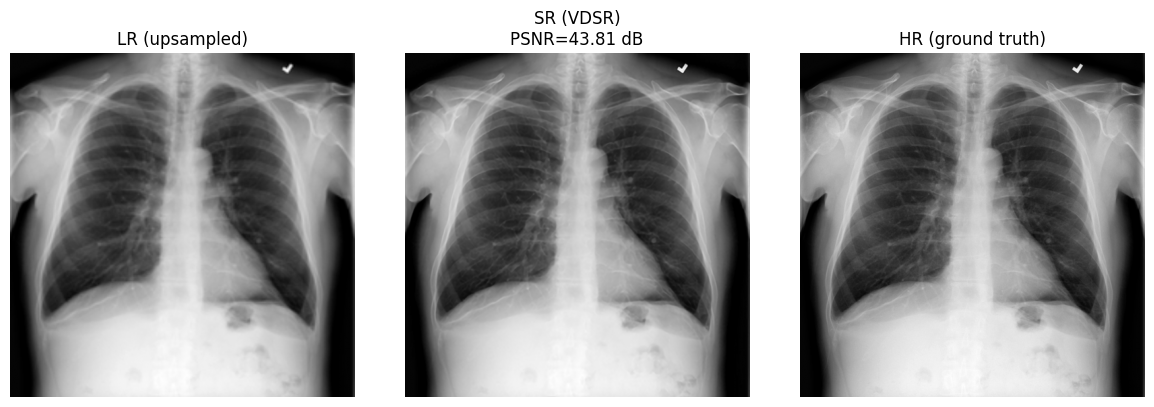

In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def psnr_torch(sr: torch.Tensor, hr: torch.Tensor, data_range: float = 1.0) -> torch.Tensor:
    mse = torch.mean((sr - hr) ** 2)
    return 20 * torch.log10(data_range / torch.sqrt(mse))


idx = random.randrange(len(train_dataset))
lr_t, hr_t = train_dataset[idx]           


lr_b = lr_t.unsqueeze(0).to(device)      
hr_b = hr_t.unsqueeze(0).to(device)

with torch.no_grad():
    sr_b = model(lr_b).clamp(0.0, 1.0)   

psnr_val = psnr_torch(sr_b, hr_b).item()
print(f"Sample #{idx} — PSNR: {psnr_val:.2f} dB")


lr_np = lr_t.squeeze().cpu().numpy()
sr_np = sr_b.squeeze().cpu().numpy()
hr_np = hr_t.squeeze().cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(lr_np, cmap='gray')
axes[0].set_title('LR (upsampled)')
axes[0].axis('off')

axes[1].imshow(sr_np, cmap='gray')
axes[1].set_title(f'SR (VDSR)\nPSNR={psnr_val:.2f} dB')
axes[1].axis('off')

axes[2].imshow(hr_np, cmap='gray')
axes[2].set_title('HR (ground truth)')
axes[2].axis('off')

plt.tight_layout()
plt.show()
